In [3]:
from collections import defaultdict
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt

## Environment Encoding

We'll encode the CSV with the following states.
- 0 is on the track.
- 1 is out of bounds.
- 2 is finish line.
- 3 is starting line.

In [32]:
class Environment():
    ACTIONS = {
        0 : (1, -1),
        1 : (1, 0),
        2 : (1, 1),
        3 : (0, -1),
        4 : (0, 0),
        5 : (0, 1),
        6 : (-1, -1),
        7 : (-1, 0),
        8 : (-1, 1)
    }

    ACTION_SPACE = len(ACTIONS)

    def __init__(self, path: str) -> None:
        self.racetrack: npt.NDArray = np.loadtxt(path, delimiter=",")
        self.starts: npt.NDArray = np.argwhere(self.racetrack == 3)
        self.ends: npt.NDArray = np.argwhere(self.racetrack == 2)
        self.reset()

    def get_actions(self):
        return [*self.ACTIONS]

    def reset(self) -> None:
        self.state: npt.NDArray = self.starts[np.random.choice(self.starts.shape[0]), :].copy()
        self.velocity: npt.NDArray = np.zeros(2, dtype=np.int32)

    def step(self, action: int, randomness: int = 0.1) -> Tuple[npt.NDArray, npt.NDArray, bool]:
        done = False
        reward = -1

        # Don't change velocity with some randomness.
        if np.random.rand() >= randomness:
            self.velocity += self.ACTIONS[action]
        self.state += self.velocity

        # Constrain to within racetrack array.
        self.state.clip(0, np.array(self.racetrack.shape) - 1, out=self.state)

        # State checks. Ignore starting state as it's only used for initialization.
        if self.racetrack[tuple(self.state)] == 1:
            reward -= 10
            self.reset()
        elif self.racetrack[tuple(self.state)] == 2:
            reward += 10
            done = True

        return self.state, reward, done

In [49]:
class Agent():
    def __init__(self, env: Environment, num_iterations: int = 1000, epsilon: float = 0.1, gamma: float = 0.9) -> None:
        self.env: Environment = env
        self.num_iterations: int = num_iterations
        self.epsilon: float = epsilon
        self.gamma: float = gamma

        shape = (*self.env.racetrack.shape, len(self.env.get_actions()))
        self.Q: npt.NDArray = np.zeros(shape)
        self.rewards: list = []
        self.policy: npt.NDArray = (1 / self.env.ACTION_SPACE) * np.ones(shape)
        self.returns: npt.NDArray = np.zeros(shape)
        self.count: npt.NDArray = np.zeros(shape)

    def print_action(self):
        for i in range(self.env.racetrack.shape[0]):
            line = "|"
            for j in range(self.env.racetrack.shape[1]):
                action = np.argmax(self.Q[(i, j)])
                line += f"{action:02}, {action:02}|"
            print(f"{line}")

    def simulate_Q(self) -> None:
        episode = self.generate_episode(training=False)
        for state, action, _ in episode:
            print(f"Position: {state[1] + 1}, {state[0] + 1} | Action: {action}")

    def plot_rewards(self) -> None:
        plt.plot(range(len(self.rewards)), self.rewards)
        plt.title("On Policy - MC Control")
        plt.xlabel("Episode")
        plt.ylabel("Undiscounted Return")     

    def generate_episode(self, training: bool = True) -> list:
        episode = []
        self.env.reset()

        done = False
        while not done:
            state = self.env.state.copy()
            probabilities = self.policy[tuple(state)]
            probabilities = probabilities / np.sum(probabilities)
            if training:
                action = np.random.choice(self.env.ACTION_SPACE, p=probabilities)
            else:
                action = np.argmax(probabilities)
            next_state, reward, done = self.env.step(action)
            episode.append((state, action, reward))
        
        return episode

    def first_visit_mc(self) -> None:
        for i in range(self.num_iterations):
            episode = self.generate_episode()
            q_visited = [tuple(state) + (action,) for (state, action, _) in episode]

            self.rewards.append(sum([step[2] for step in episode]))
            print(i, self.rewards[-1])

            G = 0
            for t, (state, action, reward) in enumerate(episode):
                state_idx = tuple(state)
                action_idx = (action,)

                G = self.gamma * G + reward # This may be backwards.

                if state_idx + action_idx not in q_visited[0:t]:
                    self.returns[state_idx + action_idx] += G
                    self.count[state_idx + action_idx] += 1
                    self.Q[state_idx + action_idx] = self.returns[state_idx + action_idx] / self.count[state_idx + action_idx]
                    optimal_action = np.argmax(self.Q[state_idx])
                    
                    for a in self.env.get_actions():
                        if (a == optimal_action).all():
                            self.policy[state_idx, a] = 1 - self.epsilon + (self.epsilon / self.env.ACTION_SPACE)
                        else:
                            self.policy[state_idx, a] = self.epsilon / self.env.ACTION_SPACE

    def every_visit_mc(self) -> None:
        for i in range(self.num_iterations):
            episode = self.generate_episode()
            self.rewards.append(sum([step[2] for step in episode]))
            print(i, self.rewards[-1])

            G = 0
            for state, action, reward in reversed(episode):
                state_idx = tuple(state)
                action_idx = (action,)

                G = self.gamma * G + reward
                self.returns[state_idx + action_idx] += G
                self.count[state_idx + action_idx] += 1
                self.Q[state_idx + action_idx] = self.returns[state_idx + action_idx] / self.count[state_idx + action_idx]
                optimal_action = np.argmax(self.Q[state_idx])
                
                for a in self.env.get_actions():
                    if (a == optimal_action).all():
                        self.policy[state_idx, a] = 1 - self.epsilon + (self.epsilon / self.env.ACTION_SPACE)
                    else:
                        self.policy[state_idx, a] = self.epsilon / self.env.ACTION_SPACE

0 -1424
1 -7091
2 -6541
3 -4052
4 -603
5 -923
6 -5545
7 -6821
8 -31
9 -2919
10 -160
11 -634
12 -1900
13 -1803
14 -114
15 -373
16 -4581
17 -907
18 -7436
19 -6160
20 -1281
21 -8240
22 -5300
23 -841
24 -819
25 -2888
26 -4205
27 -10313
28 -11704
29 -482
30 -5121
31 -227
32 -1745
33 -4885
34 -6336
35 -1092
36 -284
37 -13913
38 -3763
39 -3585
40 -5866
41 -199
42 -4116
43 -1308
44 -3926
45 -7235
46 -1542
47 -1442
48 -2496
49 -2186
50 -6305
51 -1921
52 -2316
53 -6792
54 -1676
55 -4383
56 -1405
57 -1921
58 -246
59 -3431
60 -385
61 -3426
62 -7422
63 -1673
64 -5730
65 -12183
66 -2483
67 -9225
68 -2483
69 -5010
70 -1122
71 -2723
72 -4001
73 -972
74 -17894
75 -7225
76 -4805
77 -10867
78 -3378
79 -3745
80 -10207
81 -1285
82 -3196
83 -8092
84 -189
85 -9317
86 -5127
87 -8058
88 -809
89 -5426
90 -5136
91 -4206
92 -449
93 -340
94 -6215
95 -84
96 -9075
97 -1323
98 -151
99 -14116
100 -1364
101 -5377
102 -2941
103 -8590
104 -33
105 -707
106 -4388
107 -816
108 -5598
109 -2682
110 -1701
111 -10397
112 -1620


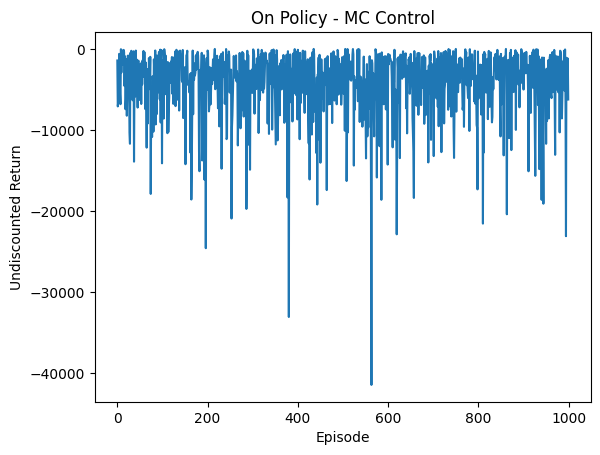

In [51]:
env = Environment("./racetrack2.csv")
agent_first_visit = Agent(env)
agent_first_visit.first_visit_mc()
agent_first_visit.print_action()
agent_first_visit.plot_rewards()

0 -1003
1 -4839
2 -11886
3 -4187
4 -4428
5 -4282
6 -3819
7 -884
8 -943
9 -111
10 -6735
11 -977
12 -622
13 -6563
14 -526
15 -971
16 -4491
17 -79
18 -3099
19 -2916
20 -17886
21 -1371
22 -3319
23 -785
24 -1798
25 -1582
26 -299
27 -5832
28 -4060
29 -3130
30 -14241
31 -10916
32 -1846
33 -132
34 -1948
35 -3437
36 -25
37 -11130
38 -1394
39 -761
40 -2465
41 -1173
42 -330
43 -2933
44 -3692
45 -2978
46 -3235
47 -4119
48 -842
49 -5738
50 -6529
51 -3105
52 -7834
53 -8046
54 -7492
55 -6184
56 -14125
57 -3617
58 -3887
59 -12549
60 -3615
61 -9577
62 -3508
63 -2184
64 -2032
65 -2898
66 -9582
67 -10240
68 -7039
69 -958
70 -487
71 -1133
72 -9822
73 -2802
74 -4575
75 -854
76 -12612
77 -6050
78 -8381
79 -3910
80 -25470
81 -1485
82 -16569
83 -1164
84 -4750
85 -3151
86 -9897
87 -22092
88 -2124
89 -22309
90 -7585
91 -851
92 -420
93 -68
94 -3627
95 -7070
96 -6287
97 -9156
98 -1729
99 -5964
100 -202
101 -4022
102 -4830
103 -5265
104 -5682
105 -6985
106 -1648
107 -2564
108 -838
109 -227
110 -2426
111 -1968
112 

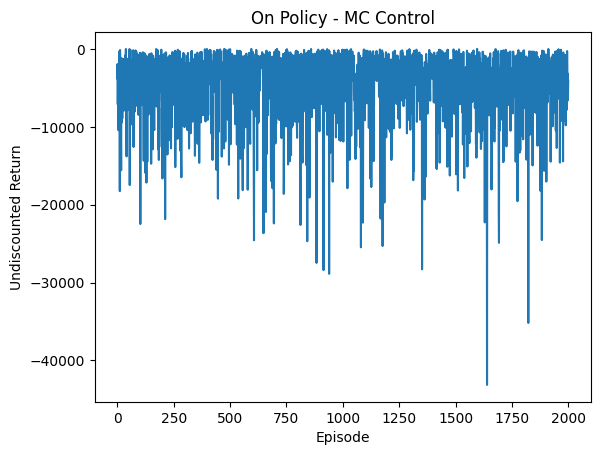

In [52]:
agent_every_visit.every_visit_mc()
agent_every_visit.print_action()
agent_every_visit.simulate_Q()
agent_every_visit.plot_rewards()